In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
H = np.array([[1.0, 0.0],
              [0.0, 50.0]])

def cost_func(v):
    return 0.5 * v.T @ H @ v

def grad(v):
    return H @ v

In [9]:
def gradient_descent(theta0, lr, iters):
    path = [theta0.copy()]
    theta = theta0.copy()

    for i in range(iters):
        g = grad(theta)
        theta = theta - lr * g
        path.append(theta.copy())

    return np.array(path)

In [10]:
theta_test = np.array([1.0, 2.0])
g = grad(theta_test)

print("theta:", theta_test)
print("Gradient:", g)


theta: [1. 2.]
Gradient: [  1. 100.]


In [11]:
theta_test = np.array([1.0, 2.0])
lr = 0.05

g = grad(theta_test)
theta_next = theta_test - lr * g

print("theta_start:", theta_test)
print("gradient:", g)
print("theta_next:", theta_next)

theta_start: [1. 2.]
gradient: [  1. 100.]
theta_next: [ 0.95 -3.  ]


In [12]:
def newton_method(theta0, iters):
    path = [theta0.copy()]
    theta = theta0.copy()
    H_inv = np.linalg.inv(H)

    for i in range(iters):
        g = grad(theta)
        theta = theta - H_inv @ g
        path.append(theta.copy())

    return np.array(path)

In [13]:
theta_test = np.array([1.0, 2.0])
newton_path = newton_method(theta_test, iters=1)

print("theta_start:", theta_test)
print("theta_after_newton:", newton_path[-1])

theta_start: [1. 2.]
theta_after_newton: [0. 0.]


In [14]:
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)

Z = 0.5 * (H[0,0]*X**2 + H[1,1]*Y**2)

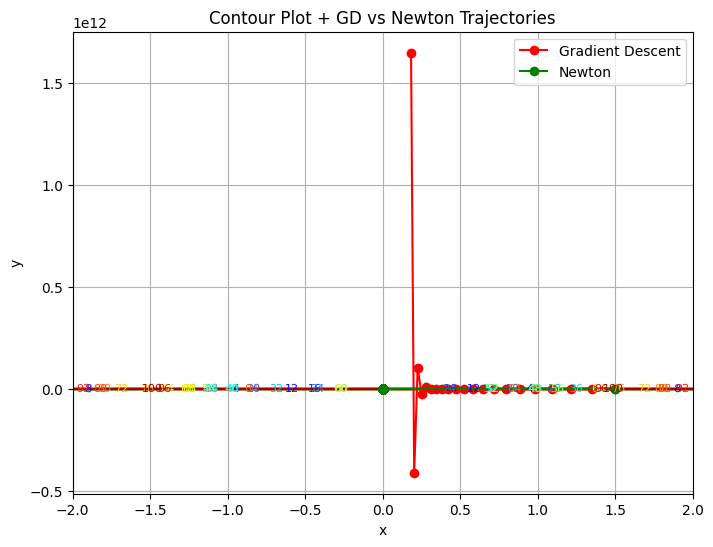

In [28]:
plt.figure(figsize=(8, 6))
contours = plt.contour(X, Y, Z, levels=30, cmap="jet")
plt.clabel(contours, inline=True, fontsize=8)
theta0 = np.array([1.5, 1.5])

gd_path = gradient_descent(theta0, lr=0.1, iters=20)
newton_path = newton_method(theta0, iters=300)
plt.plot(gd_path[:, 0], gd_path[:, 1], 'o-', color='red', label='Gradient Descent')
plt.plot(newton_path[:, 0], newton_path[:, 1], 'o-', color='green', label='Newton')
plt.title("Contour Plot + GD vs Newton Trajectories")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
def conjugate_gradient(theta0, iters):
    path = [theta0.copy()]
    theta = theta0.copy()
    r = grad(theta)
    p = -r
    for i in range(iters):
        Hp = H @ p
        alpha = (r.T @ r) / (p.T @ Hp)
        theta = theta + alpha * p
        path.append(theta.copy())
        r_new = r + alpha * Hp
        beta = (r_new.T @ r_new) / (r.T @ r)
        p = -r_new + beta * p
        r = r_new
    return np.array(path)

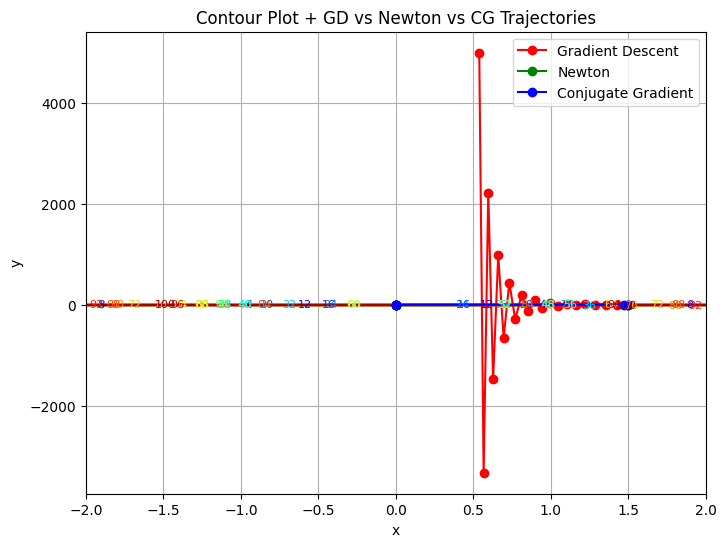

In [30]:
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)
Z = 0.5 * (H[0,0]*X**2 + H[1,1]*Y**2)

plt.figure(figsize=(8, 6))
contours = plt.contour(X, Y, Z, levels=30, cmap="jet")
plt.clabel(contours, inline=True, fontsize=8)

theta0 = np.array([1.5, 1.5])
gd_path = gradient_descent(theta0, lr=0.05, iters=20)
newton_path = newton_method(theta0, iters=3)
cg_path = conjugate_gradient(theta0, iters=5)

plt.plot(gd_path[:, 0], gd_path[:, 1], 'o-', color='red', label='Gradient Descent')
plt.plot(newton_path[:, 0], newton_path[:, 1], 'o-', color='green', label='Newton')
plt.plot(cg_path[:, 0], cg_path[:, 1], 'o-', color='blue', label='Conjugate Gradient')
plt.title("Contour Plot + GD vs Newton vs CG Trajectories")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from scipy.optimize import minimize
import time

In [3]:
data = load_breast_cancer()
X, y = data.data, data.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [4]:
class ShallowMLP:
    def __init__(self, input_dim=30, hidden_dim=5, output_dim=1):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01
        self.b2 = np.zeros((1, output_dim))
        
        self.params_count = (
            input_dim * hidden_dim + hidden_dim +
            hidden_dim * output_dim + output_dim
        )
        print(f"Total parameters: {self.params_count}")
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def forward(self, X):
        self.z1 = X.dot(self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    def loss(self, y_pred, y_true):
        m = y_true.shape[0]
        loss = -np.mean(y_true * np.log(y_pred + 1e-8) + 
                       (1 - y_true) * np.log(1 - y_pred + 1e-8))
        return loss
    
    def gradients(self, X, y):
        m = X.shape[0]
        y_pred = self.forward(X)
        
        dz2 = y_pred - y.reshape(-1, 1)
        dW2 = (1/m) * self.a1.T.dot(dz2)
        db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)
        
        dz1 = dz2.dot(self.W2.T) * (self.a1 * (1 - self.a1))
        dW1 = (1/m) * X.T.dot(dz1)
        db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)
        
        return dW1, db1, dW2, db2
    
    def get_params(self):
        params = np.concatenate([
            self.W1.flatten(),
            self.b1.flatten(),
            self.W2.flatten(),
            self.b2.flatten()
        ])
        return params
    
    def set_params(self, params):
        w1_size = self.input_dim * self.hidden_dim
        b1_size = self.hidden_dim
        w2_size = self.hidden_dim * self.output_dim
        b2_size = self.output_dim
        
        self.W1 = params[:w1_size].reshape(self.input_dim, self.hidden_dim)
        self.b1 = params[w1_size:w1_size+b1_size].reshape(1, self.hidden_dim)
        self.W2 = params[w1_size+b1_size:w1_size+b1_size+w2_size].reshape(self.hidden_dim, self.output_dim)
        self.b2 = params[w1_size+b1_size+w2_size:].reshape(1, self.output_dim)

In [5]:
def train_sgd(model, X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    train_losses = []
    test_losses = []
    times = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        y_pred_train = model.forward(X_train)
        train_loss = model.loss(y_pred_train, y_train)
        
        dW1, db1, dW2, db2 = model.gradients(X_train, y_train)
        
        model.W1 -= lr * dW1
        model.b1 -= lr * db1
        model.W2 -= lr * dW2
        model.b2 -= lr * db2
        
        y_pred_test = model.forward(X_test)
        test_loss = model.loss(y_pred_test, y_test)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        times.append(time.time() - start_time)
    
    return train_losses, test_losses, times

In [ ]:
def loss_wrapper(params, model, X, y):
    model.set_params(params)
    y_pred = model.forward(X)
    loss = model.loss(y_pred, y)
    return loss

def grad_wrapper(params, model, X, y):
    model.set_params(params)
    model.forward(X)
    dW1, db1, dW2, db2 = model.gradients(X, y)
    
    grad = np.concatenate([
        dW1.flatten(),
        db1.flatten(),
        dW2.flatten(),
        db2.flatten()
    ])
    return grad

def train_bfgs(model, X_train, y_train, X_test, y_test):
    train_losses = []
    test_losses = []
    times = []
    
    start_time = time.time()
    
    def callback(params):
        model.set_params(params)
        
        y_pred_train = model.forward(X_train)
        train_loss = model.loss(y_pred_train, y_train)
        
        y_pred_test = model.forward(X_test)
        test_loss = model.loss(y_pred_test, y_test)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        times.append(time.time() - start_time)
    
    initial_params = model.get_params()
    
    result = minimize(
        fun=loss_wrapper,
        x0=initial_params,
        args=(model, X_train, y_train),
        method='L-BFGS-B',
        jac=grad_wrapper,
        callback=callback,
        options={'maxiter': 100, 'disp': False}
    )
    
    model.set_params(result.x)
    
    return train_losses, test_losses, times